In [27]:
import pandas as pd
import numpy as np
from scipy import optimize
from matplotlib import pyplot as plt

In [28]:
data = pd.read_csv("data.csv")

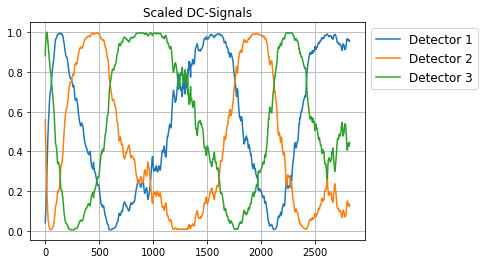

In [29]:
plt.plot(range(len(data["Norm DC1 (V)"])), data["DC D1 con scaled"], label="Detector 1")
plt.plot(range(len(data["Norm DC1 (V)"])), data["DC D2 con scaled"], label="Detector 2")
plt.plot(range(len(data["Norm DC1 (V)"])), data["DC D3 con scaled"], label="Detector 3")
plt.legend(fontsize=12, bbox_to_anchor=(1,1))
plt.grid(True)
plt.title("Scaled DC-Signals", fontsize=12)
plt.show()

In [30]:
def scale_edata(data):
    return 2 * (data - min(data)) / (max(data) - min(data)) - 1

In [31]:
dc_1_scaled = scale_edata(data["DC D1 con scaled"])
dc_2_scaled = scale_edata(data["DC D2 con scaled"])
dc_3_scaled = scale_edata(data["DC D3 con scaled"])

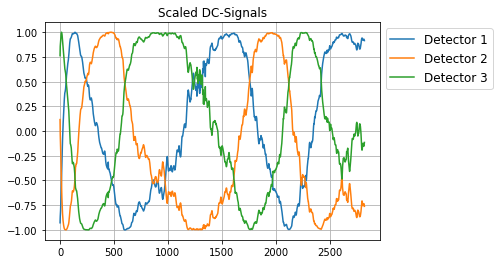

In [32]:
plt.plot(range(len(data["Norm DC1 (V)"])), dc_1_scaled, label="Detector 1")
plt.plot(range(len(data["Norm DC1 (V)"])), dc_2_scaled, label="Detector 2")
plt.plot(range(len(data["Norm DC1 (V)"])), dc_3_scaled, label="Detector 3")
plt.legend(fontsize=12, bbox_to_anchor=(1,1))
plt.grid(True)
plt.title("Scaled DC-Signals", fontsize=12)
plt.show()

In [33]:
def ellipse(z):
    x = []
    y = []
    for i in range(len(dc_1_scaled)):
        i_0 = dc_1_scaled[i]
        i_1 = dc_2_scaled[i]
        i_2 = dc_3_scaled[i]
        x.append(i_0 + i_1 * np.cos(z[0]) + i_2 * np.cos(z[1]))
        y.append(i_1 * np.sin(z[0]) + i_2 * np.sin(z[1]))
    x, y = np.array(x), np.array(y)
    return x, y

In [34]:
def standard_deviation_circle(z):
  x, y = ellipse(z)
  return np.var(x ** 2 + y ** 2)

In [35]:
res = optimize.minimize(standard_deviation_circle, x0=np.array([2 * np.pi / 3, 4 * np.pi / 3]))
x, y = ellipse(res.x)
phi_d = [0, res.x[0], res.x[1]]

Maximum value of x and y: x = 1.4978582907344113, y = 1.4973759521460894         
Minimum value of x and y: x = -1.5030039007377398, y = -1.4963948489496248
System phases are 122.42843819591293° and 238.87176559654299°


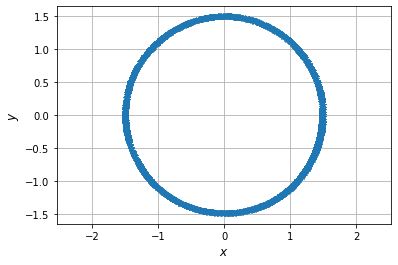

In [36]:
print(f"Maximum value of x and y: x = {max(x)}, y = {max(y)} \
        \nMinimum value of x and y: x = {min(x)}, y = {min(y)}")
print(f"System phases are {phi_d[1] / np.pi * 180}° and {phi_d[2] / np.pi * 180}°")
plt.plot(x, y, "*")
plt.grid(True)
plt.xlabel("$x$", fontsize=12)
plt.ylabel("$y$", fontsize=12)
plt.axis("equal")
plt.show()

In [37]:
phi = []
system_phase = [0, 0, 0]
for i in range(len(data[f"X1"])):
    delta_phi = []
    weight = []
    for j in range(1, 4):
        X = data[f"Norm D{j}X"][i]
        Y = data[f"Norm D{j}Y"][i]
        R = np.sqrt(X ** 2 + Y ** 2)
        theta = np.arctan2(Y, X)
        dms = 1/2 * R * np.cos(theta - system_phase[j - 1])
        x = dc_1_scaled[i] + dc_2_scaled[i] * np.cos(phi_d[1]) + dc_3_scaled[i] * np.cos(phi_d[2])
        y = dc_2_scaled[i] * np.sin(phi_d[1]) + dc_3_scaled[i] * np.sin(phi_d[2])
        signal_phase =  np.arctan2(y, x)
        delta_phi.append(dms / np.cos(signal_phase - phi_d[j - 1]))
        weight.append(np.abs(np.cos(signal_phase - phi_d[j - 1])))
    delta_phi = np.array(delta_phi)
    weight = np.array(weight)
    phi.append(np.sum(delta_phi * weight) / np.sum(weight))

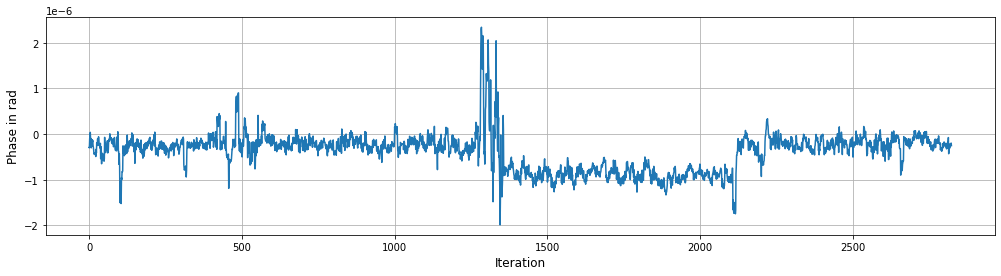

In [38]:
figure = plt.figure()
figure.set_figwidth(17)
plt.plot(range(len(phi)), phi)
plt.grid(True)
plt.xlabel("Iteration", fontsize=12)
plt.ylabel("Phase in rad", fontsize=12)
plt.show()

In [39]:
with open("phases.csv", "w") as f:
  f.write("Phase in rad\n")
  for phase in phi:
    f.write(f"{phase}\n")